This notebook is a model designed to predict a player's position based on their stats

1. Import Libraries

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2. Classify positions as midfielders, forwards and defenders

In [7]:
# Load data
fifa_21 = pd.read_csv('players_21.csv')

# Preprocess target: simplify player_positions to primary position and map to broad categories
fifa_21['player_positions'] = fifa_21['player_positions'].str.split(',')
fifa_21['primary_position'] = fifa_21['player_positions'].apply(lambda x: x[0].strip() if isinstance(x, list) and len(x) > 0 else None)

# Map detailed positions to broad categories
position_map = {
    'GK': 'Goalkeeper',
    'CB': 'Defender', 'LB': 'Defender', 'RB': 'Defender', 'LWB': 'Defender', 'RWB': 'Defender',
    'CDM': 'Midfielder', 'CM': 'Midfielder', 'CAM': 'Midfielder', 'LM': 'Midfielder', 'RM': 'Midfielder',
    'LW': 'Forward', 'RW': 'Forward', 'CF': 'Forward', 'ST': 'Forward'
}

fifa_21['broad_position'] = fifa_21['primary_position'].map(position_map)

3. Clean data and set up targets

In [8]:
# Drop rows with missing positions or missing key stats
fifa_21.dropna(subset=['broad_position', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic'], inplace=True)

# Features and target
features = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
X = fifa_21[features]
y = fifa_21['broad_position']

# Remove positions with fewer than 2, so rare positions like RF
#  Can't train model on a few players
value_counts = y.value_counts()
valid_classes = value_counts[value_counts >= 2].index
mask = y.isin(valid_classes)
X = X[mask]
y = y[mask]

4. Train model and give confusion matrix

              precision    recall  f1-score   support

    Defender       0.86      0.88      0.87      1241
     Forward       0.84      0.80      0.82       724
  Midfielder       0.80      0.81      0.80      1407

    accuracy                           0.83      3372
   macro avg       0.84      0.83      0.83      3372
weighted avg       0.83      0.83      0.83      3372



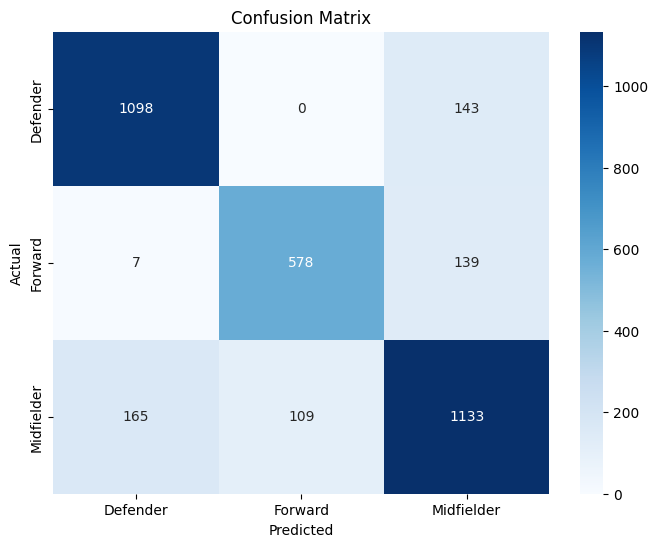

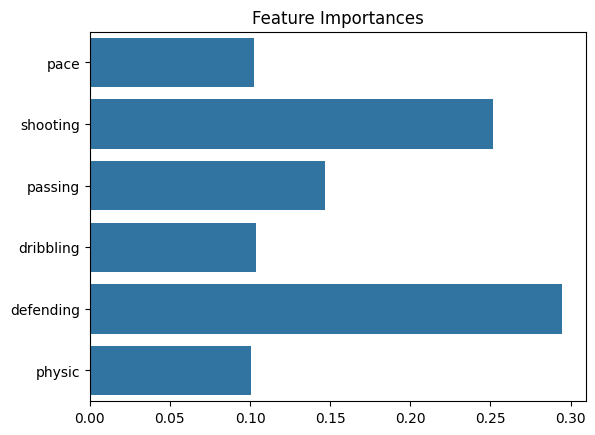

In [9]:
# Encode target labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, stratify=y_enc, random_state=42, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
importances = model.feature_importances_
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.show()


For Defenders:

1098 were correctly predicted as Defender (true positives for Defender).

143 were misclassified as Midfielder.

None were misclassified as Forward.

For Forwards:

578 were correctly predicted as Forward.

7 were misclassified as Defender.

139 were misclassified as Midfielder.

For Midfielders:

1133 were correctly predicted as Midfielder.

165 were misclassified as Defender.

109 were misclassified as Forward.

High f1-scores, precision and recall.

This shows that the model is accurate at predicting the correct positions, expected errors may have been from misclassifying between midfielders and forwards as some midfielders are attack-based which can only be distinguished from forwards if their defensive stats are impactful.

The feature importance shows the model gives significance to defending since it is most important in determining defenders, since they only have high defense, it also gives importance to shooting since only forwards are likely to have high shooting stats